## 13 + train f() using a combination of mu_bar and mu

In [205]:
# %%
import torch
from torch import nn
import pdb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import random
%matplotlib inline

from scipy.stats import norm

def normal_distribution(n, mean, var=0.05):
  x = norm.pdf(np.arange(0, 1, 1.0 / n), mean, var)
  x = x / np.sum(x)
  return torch.tensor(x).float()

def bhattacharya_distance(hist1,  hist2):
  hist1[hist1<0] = 0
  hist2[hist2<0] = 0

  a = 1 / (np.sum(hist1, axis=1) * np.sum(hist2, axis=1))
  b = np.sum(np.sqrt(hist1 * hist2), axis=1)
  return np.sqrt(1-a*b)

def imshow(title, image, vmin=0, vmax=1):
  plt.figure(figsize=figsize)
  plt.title("{2} [{0}, {1}]".format(np.amin(image), np.amax(image), title))
  plt.title(title)
  plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
  plt.show()
    
def plot_errors(e):
    imshow('prediction errors', e, vmin=None, vmax=None)

    abs_errors = np.abs(e)
    imshow('abs_errors', abs_errors, vmin=None, vmax=None)

    positive_errors = errors.copy()
    positive_errors[positive_errors<0] = 0
    imshow('positive_errors', positive_errors, vmin=None, vmax=None)

    negative_errors = errors.copy()
    negative_errors[negative_errors>0] = 0
    negative_errors = negative_errors * -1
    imshow('negative_errors', negative_errors, vmin=None, vmax=None)

def sigmoid_array(x):                                        
    return 1 / (1 + np.exp(-x))

# signal is t_steps X quantization
def precision(signal):
    normalized = sigmoid_array(signal)
    return np.max(normalized, axis=0) * 4 - 2

figsize=(15,5)
quantization = 20

## Training pattern: sin() with a bit of noise, normal distribution around mean

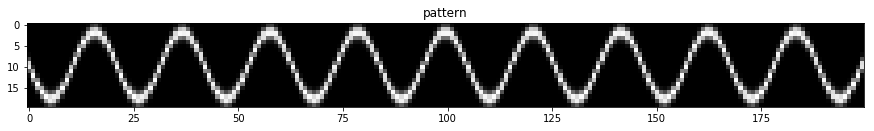

In [109]:
pattern_length = 200
pattern_floats = torch.tensor((np.sin(np.arange(pattern_length) * 0.30) + 1.2 + np.random.sample(int(pattern_length)) * 0) / 2.5).float()
pattern = torch.stack([normal_distribution(quantization, val, var=0.05) for val in pattern_floats])
pattern = pattern / pattern.max().item() # normailze to probability distribution, i.e. sum = 1.0

imshow('pattern', pattern.t().numpy())

## Train an RNN to predict pattern
Use a random intensity value between 0 and 1 for each epoch.

/Users/amolk/work/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/Users/amolk/work/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


epoch  0


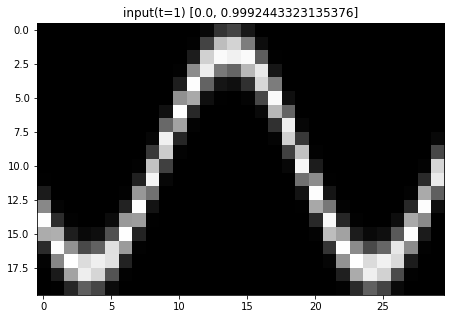

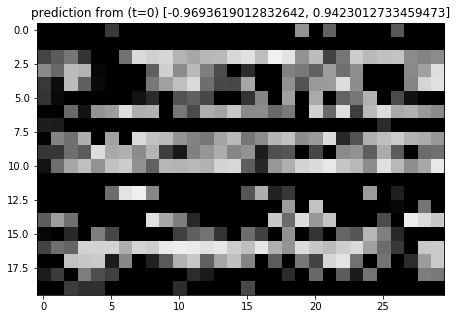

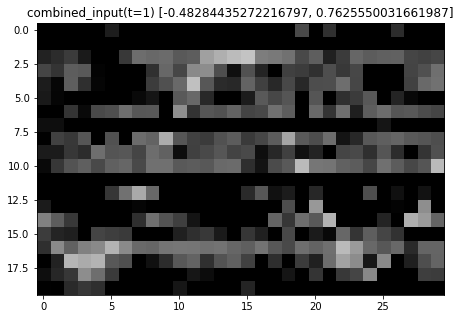

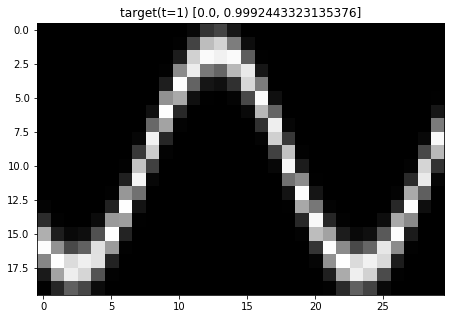

epoch  400


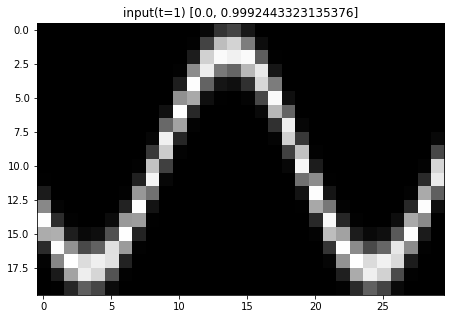

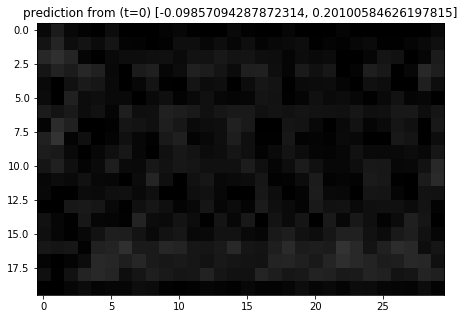

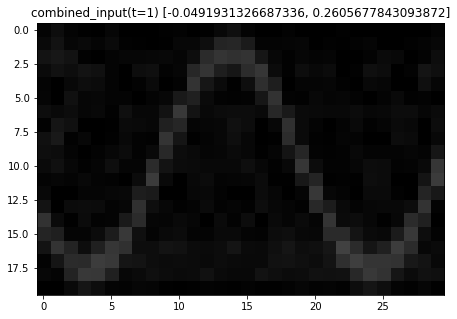

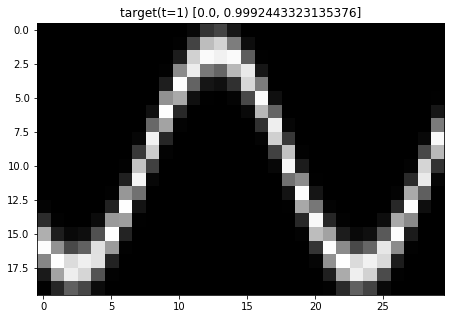

epoch  800


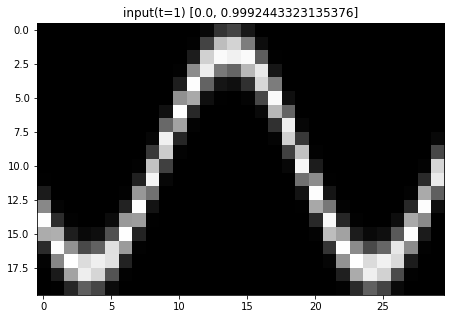

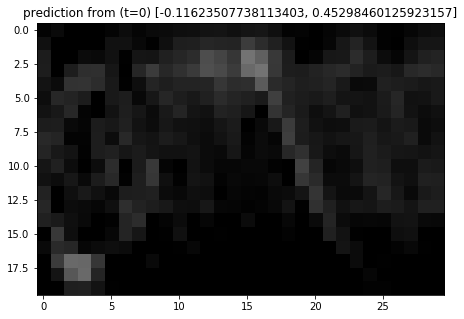

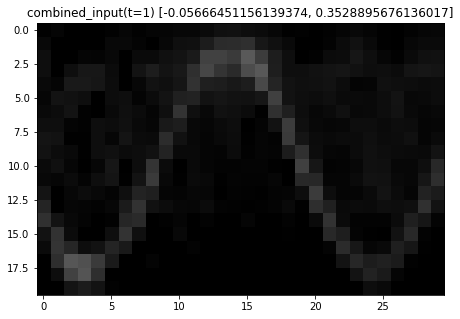

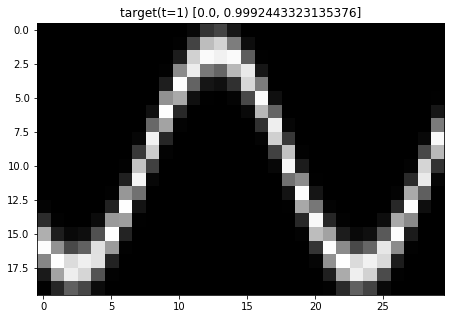

epoch  1200


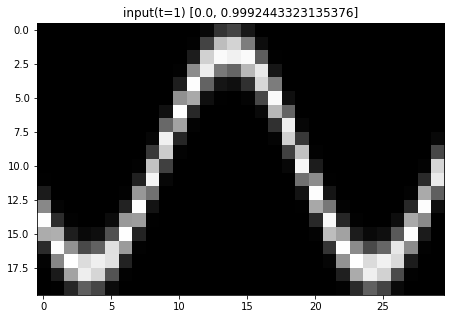

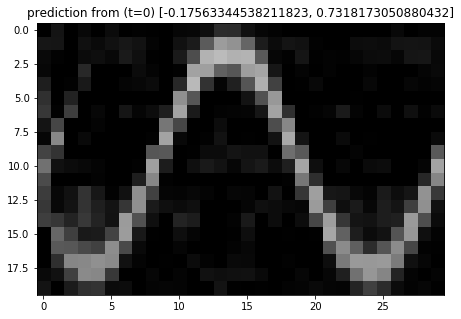

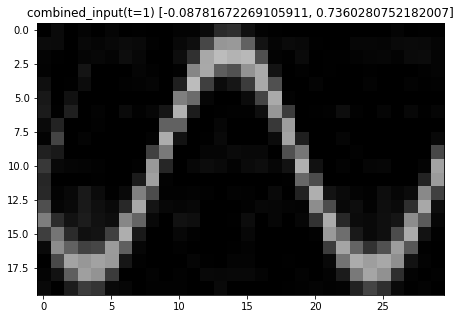

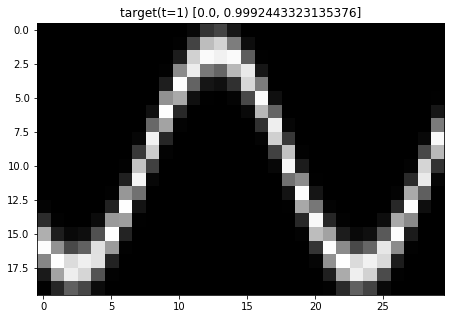

epoch  1600


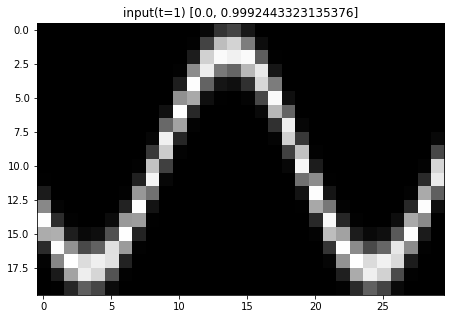

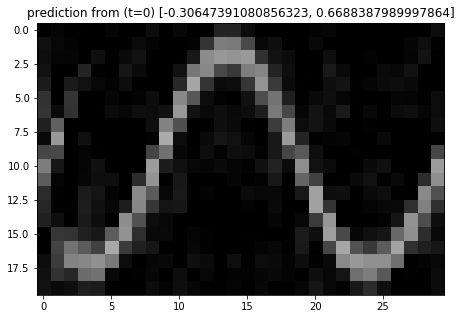

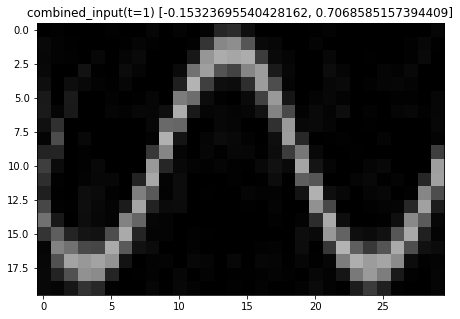

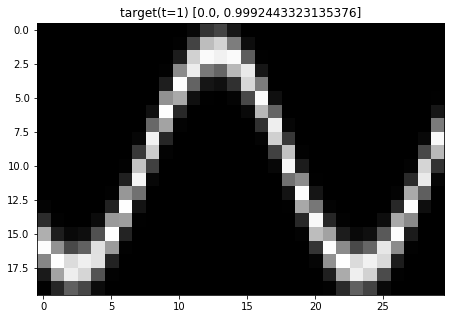

epoch  2000


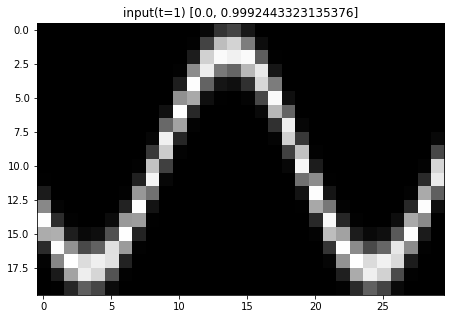

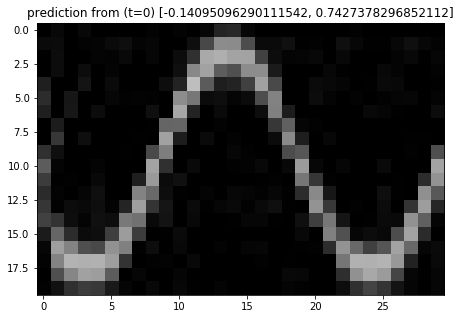

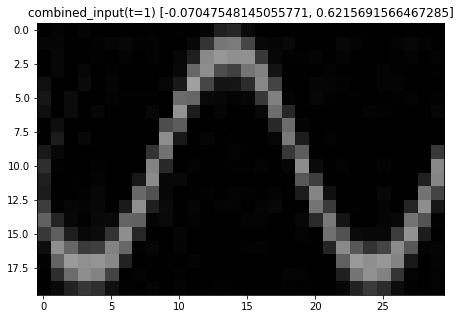

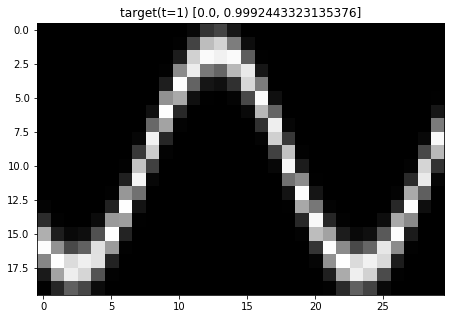

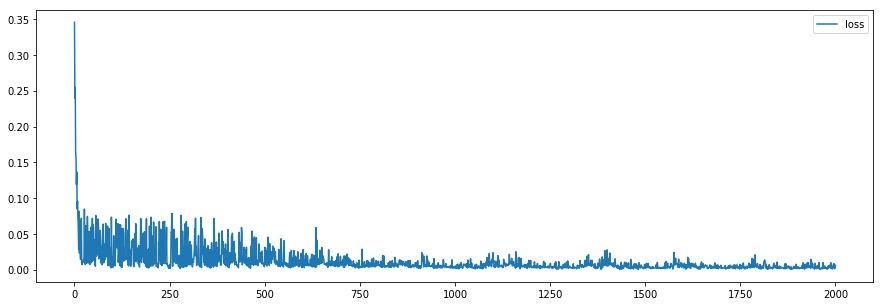

In [225]:
# %%
t_sample = 30
batch_size = pattern_length - t_sample - 1
input = torch.stack([pattern[i:i+t_sample] for i in np.arange(batch_size)])
target = torch.stack([pattern[i+1:i+t_sample+1] for i in np.arange(batch_size)])

hidden_size = t_sample

# %%
num_layers=10
rnn = nn.RNN (
  input_size=quantization,
  hidden_size=quantization,
  num_layers=num_layers,
  nonlinearity='tanh',
  batch_first=True
)

for name, param in rnn.named_parameters():
  if 'bias' in name:
     nn.init.constant(param, 0.0)
  elif 'weight' in name:
    nn.init.xavier_normal(param)

learning_rate = 0.01
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
epoch = 0
losses = []
while epoch < 2001:
  scale = random.random()

  # get predictions
  rnn.zero_grad()
  state = torch.zeros(num_layers, batch_size, quantization)
  out, state = rnn(input * scale, state)
    
  # use predictions (mu_bar) and input (mu) for training
  #print("input shape ", input[1:].shape)
  #print("out shape ", out[0:-1].shape)
  combined_input = (input[1:] * scale + out[:-1].detach()) / 2
  #print("combined_input shape ", combined_input.shape)
  if epoch %400 == 0:
    i = 1
    print('epoch ', epoch)
    imshow('input(t=1)', input[i+1].detach().t().numpy())
    imshow('prediction from (t=0)', out[i].detach().t().numpy())
    imshow('combined_input(t=1)', combined_input[i].t().numpy()) # 0th entry is for t=1
    imshow('target(t=1)', target[i+1].detach().t().numpy())

  #print('batch_size ', batch_size)
  rnn.zero_grad()
  state = torch.zeros(num_layers, batch_size-1, quantization)
  out, state = rnn(combined_input, state)
  #predictions = out[:, -1].detach()

  # out = linear(out)
  # print('out', out)
  # print('state', state)
  #torch.nn.functional.relu_(out)
  loss = torch.nn.functional.mse_loss(out, target[1:] * scale)
  loss.backward()
  optimizer.step()
  # print('loss', loss)
  losses.append(loss)

  epoch += 1

plt.figure(figsize=figsize)
plt.plot(losses, label='loss')
plt.legend()
plt.show()

X axis shows intensity of signal. The network trained within intensity range (0, 1].

The 'intensity / error range' curve above indicates that at low intensity levels, predictions have low signal to noise ratio. The following extrapolations could be made -
- in low light/exposure condition, predictions are less precise
- precision improves with brighter exposure conditions
- over-exposure also leads to less precision
- optimial exposure conditions are near 60-80% intensity

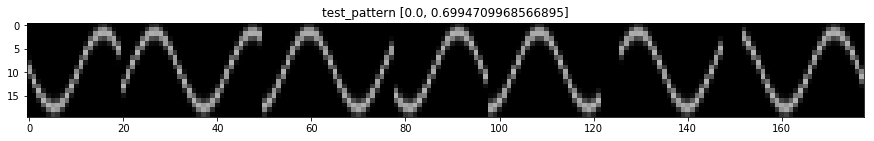

In [226]:
# %%
test_pattern = torch.cat([pattern[0:int(pattern_length*0.10)], pattern[int(pattern_length*0.15):int(pattern_length*0.30)], pattern[int(pattern_length*0.45):int(pattern_length*0.59)], pattern[int(pattern_length*0.85):int(pattern_length*0.95)], pattern[int(pattern_length*0.55):int(pattern_length*0.95)]]) * 0.7
# blank out parts of the signal to observe illusory contours
test_pattern[122:126, :] = 0
test_pattern[148:152, :] = 0

test_pattern_length = test_pattern.shape[0]
imshow('test_pattern', test_pattern.t().numpy())
test_batch_size = test_pattern_length - t_sample - 1
test_input = torch.stack([test_pattern[i:i+t_sample] for i in np.arange(test_batch_size)])
test_target = torch.stack([test_pattern[i+1:i+t_sample+1] for i in np.arange(test_batch_size)])

## Sample output of RNN

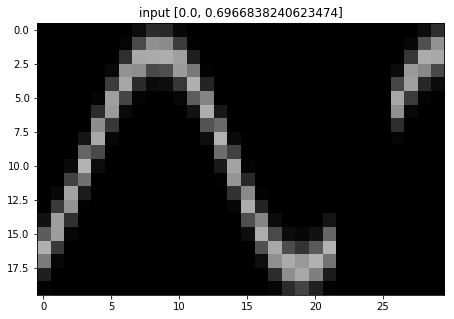

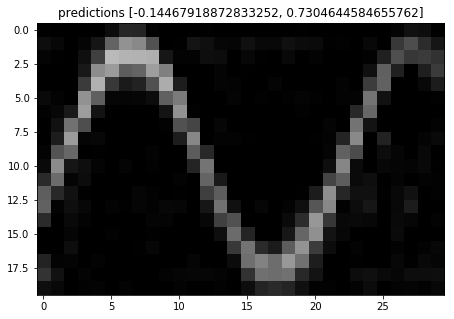

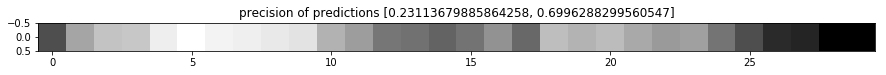

In [227]:
# %%
scale = 0.7
state = torch.zeros(num_layers, test_batch_size, quantization)
out, state = rnn(test_input * scale, state)

combined_input = (test_input[1:] * scale + out[:-1].detach()) / 2
state = torch.zeros(num_layers, test_batch_size - 1, quantization)
out, state = rnn(combined_input, state)

#torch.nn.functional.relu_(out)

index = 100
predictions = out[index].detach().t().numpy()
imshow('input', test_input[index].detach().t().numpy())
imshow('predictions', predictions)
imshow('precision of predictions', [precision(predictions)], vmin=None, vmax=None)

Notice illusory contour with slightly weaker precision

## Predictions

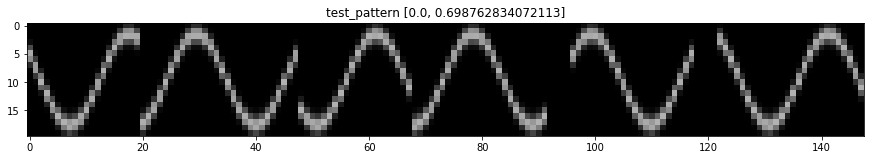

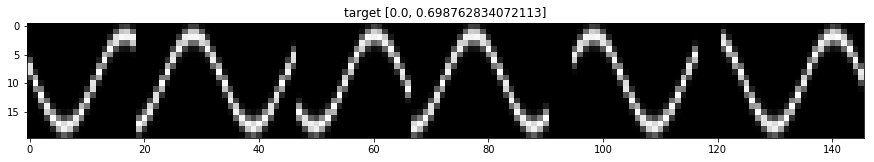

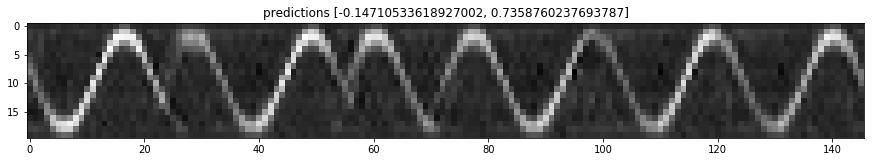

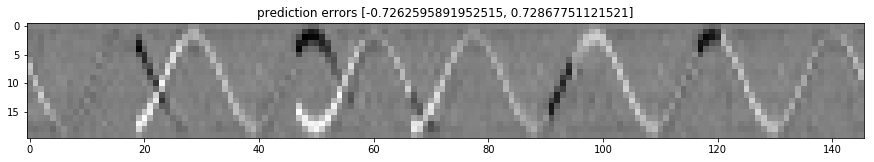

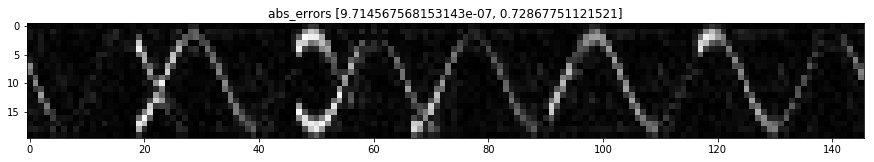

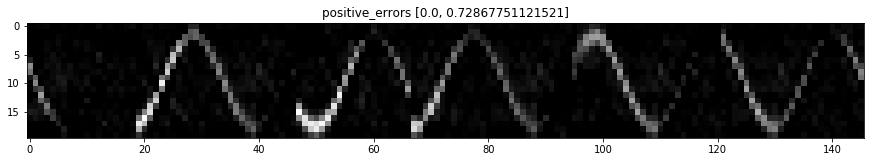

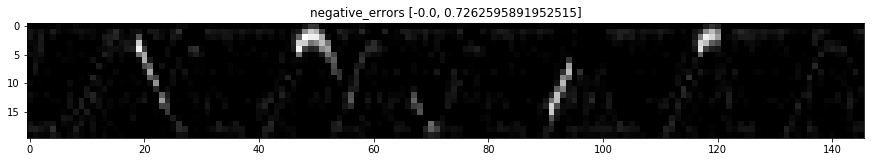

In [228]:
imshow('test_pattern', test_pattern[t_sample:].t().numpy())

target_predictions = test_target[1:, -1, :].t().numpy()
imshow('target', target_predictions, vmin=None, vmax=None)

# last entry in out is the prediction
predictions = out[:, -1].detach().numpy()
#predictions[predictions<0] = 0
predictions = predictions.transpose()
imshow('predictions', predictions, vmin=None, vmax=None)

#predictions = predictions - np.min(predictions, 0)
#imshow('normalized predictions', predictions, vmin=None, vmax=None)

errors = target_predictions - predictions
plot_errors(errors)



Predictions errors -
- show negative (dark) 'illusory contours', expected signal that was not received
- when there is abrupt change in sensory input, positive (light) errors indicate the signal that was received
- after illusory contours, we notice positive (light) error. This is most likely an artefact caused by not using the predictions as part of future input to the RNN, i.e. we did not allow the RNN to hallucinate. We will need an online method to integrate predictions and sensory input at each time step, to be used for predictions in the next time step.

Notice that the prediction errors in 14 are more well defined than in 13. Training f() with combined mu_bar and mu seems to improve the ability of f() to predict with confidence.

## Next steps
- train g(hidden state, mu-(mu_bar + mu_hat))
- use 2D sample instaead of single point
- use multiple layers